In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.special import erf

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34  # reduced Planck constant
options = Options()

In [2]:
Nq = 2  # number of levels in qubit

wq = 7e9*2*pi  # qubit frequency
"""
What frequency? Of its ground state? Is this the so-called plasma frequency?
"""
wp = wq        # pump frequency

kq = 50e3*2*pi  # photon emission frequency of qubit (qubit decay rate)

Ec = 200e6*2*pi  # Anharmonicity

t0 = 0            # start Gaussian pulse Omega
t1 = t0 + 50e-9   # end Gaussian pulse Omega
t2 = t1 + 10e-9   # start square pulse at resonator 1
t3 = t2 + 300e-9  # end square pulse at resonator 1
t4 = t3 + 10e-9   # start square pulse at resonator 2
t5 = t4 + 300e-9  # end square pulse at resonator 2
t6 = t5 + 10e-9   # t0
tg = 10e-9        # Gaussian rise and fall time of square pulse
"""
Should we divide the times by 2pi in order to be consistant with the radians in the frequencies?
"""

N_repeat = 1  # number of times to repeat cycle
"""
TODO: repeat cycle N_repeat times
"""
Q = 3  # number of std's in Gaussian curves, rises and falls

In [3]:
# Qubit operators
b = destroy(Nq)
nq = b.dag()*b
sx = sigmax() # x-projection of qubit level
sy = sigmay() # y-projection of qubit level
sz = sigmaz() # z-projection of qubit level

# Jaynes-Cummings Hamiltonian
Hjc = - Ec/2*b.dag()*b.dag()*b*b
"""
Does the derivative term of the unity operator still
have to be added?
"""

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "Q"  : Q}

In [4]:
def pump_strength(args):
    t0 = args['t0']
    t1 = args['t1']
    Q  = args['Q']
    tau = t1-t0      # pulse duration
    std = tau/(2*Q)  # standard deviation
    time = lambda t : t/(std*sqrt(2))  # t' to pass to error function
    
    """
    TODO: include qubit decay rate kq
    """
    
    integral = sqrt(2*pi)*std*erf(time(tau)/2)
    Omega = pi/integral
    return Omega

# Pump Hamiltonian
Omega = pump_strength(H_args)
H_args['Omega'] = Omega
Hp = Omega/2*(b + b.dag())  # including rotating frame approximation

In [5]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c_ops = [cq]

# Expectation operators
e_ops = [nq, sx, sy, sz]

In [6]:
def pump(t, args):
    t0 = args['t0']  # start of pulse
    t1 = args['t1']  # end of pulse
    Q  = args['Q']
    
    mu = (t1-t0)/2  # pulse center in time domain
    std = (t1-t0)/(2*Q)  # standard deviation
    confine = np.heaviside((t-t0), 0) - np.heaviside((t-t1), 0)  # entire pulse
    
    pulse = exp(-(t-mu)**2/(2*std**2))*confine
    return pulse

In [7]:
H = [Hjc, [Hp, pump]]  # complete Hamiltonian
tlist = np.linspace(0, 1*N_repeat*t6, 1000)  # discrete time steps for which to store the output
psi0 = basis(Nq,0)  # initial state
options.nsteps = 1e5  # max number of steps to take for each interval
options.store_states=True

result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)

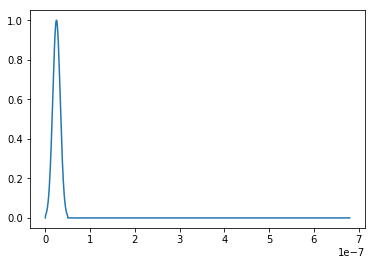

In [8]:
pulse = pump(tlist, H_args)
plt.plot(tlist, pulse)

Text(0,0.5,'$n_q$')

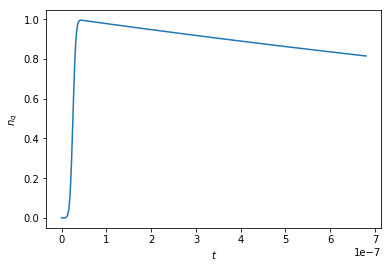

In [13]:
plt.plot(tlist, result.expect[0])
plt.xlabel("$t$")
plt.ylabel("$n_q$")

In [10]:
"""
If the qubit is in its excited state it will loose energy due to the collapse operator,
but no cavities are simulated. Where does the energy flow to?
Apparently, QuTiP does not consider energy conservation?
"""

'\nIf the qubit is in its excited state it will loose energy due to the collapse operator,\nbut no cavities are simulated. Where does the energy flow to?\nApparently, QuTiP does not consider energy conservation?\n'